## Import and Libraries

In [12]:
import kagglehub
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report

In [13]:
# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\andre\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2


## Dataset 

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Using 2806 files for validation.


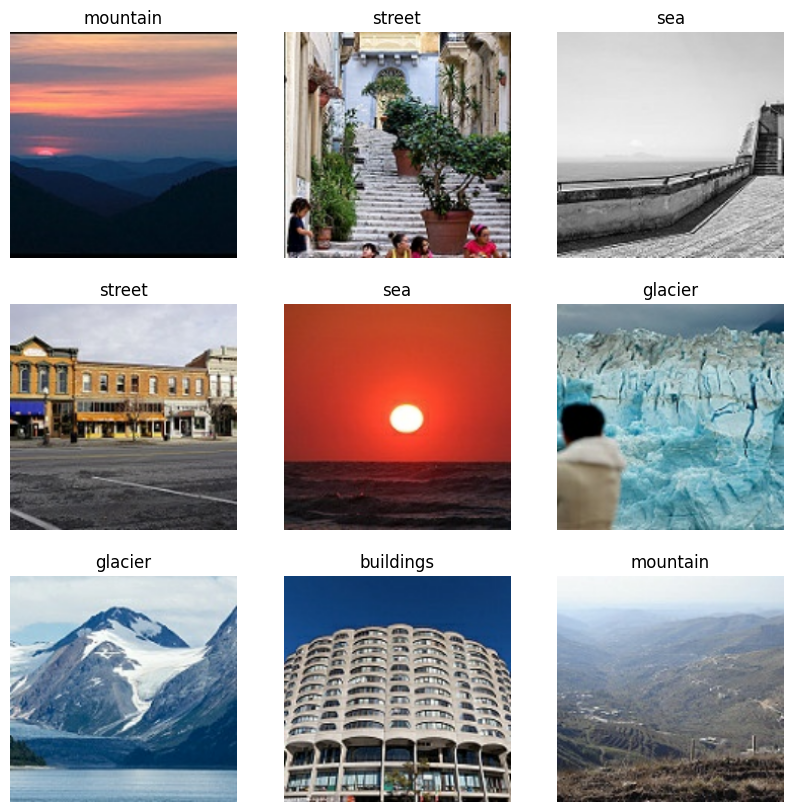

In [14]:
# Percorso aggiornato al dataset di training
path_train = r"C:\Users\andre\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2\seg_train\seg_train"

# Recupero delle classi (nomi delle sottocartelle)
subfolders = glob.glob(path_train + "/*")
classes = [subfolder.split(path_train + "\\")[1] for subfolder in subfolders]

# Creazione del dataset senza suddivisione, considerando solo il training set
train, validation = keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(224, 224),
    batch_size=32,
    subset='both',
    validation_split = 0.20,
    label_mode='categorical',
    shuffle=True,
    seed=2
)

# Visualizzazione di alcune immagini
dataset_iterator = iter(train.take(1))
images, labels = next(dataset_iterator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[np.argmax(labels[i])])
    plt.axis("off")
plt.show()

Found 3000 files belonging to 6 classes.


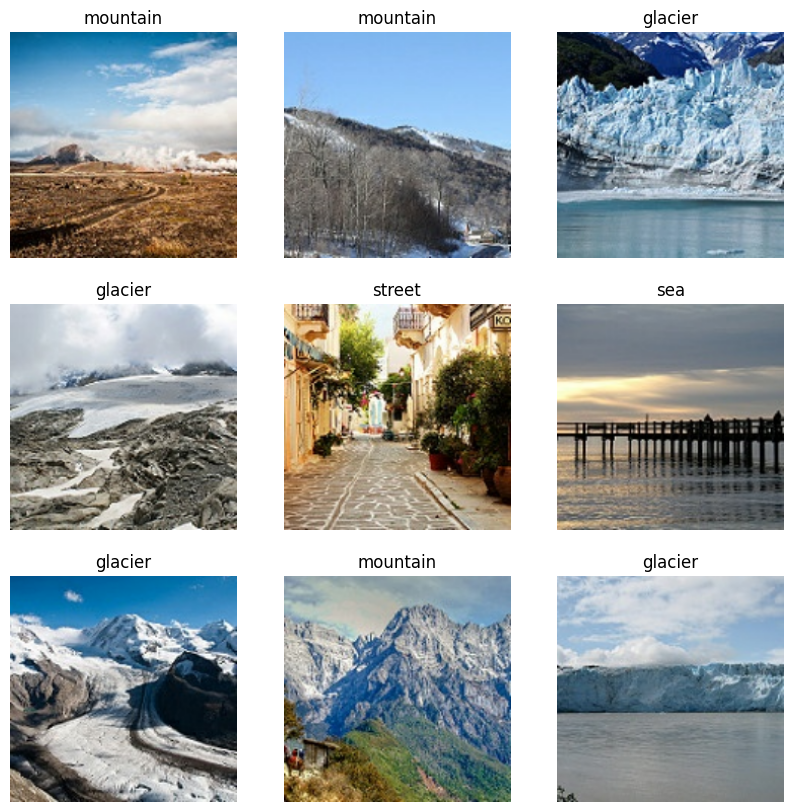

Training set size: 3000


In [15]:
# Percorso aggiornato al dataset di training
path_test = r"C:\Users\andre\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2\seg_test\seg_test"

# Recupero delle classi (nomi delle sottocartelle)
subfolders = glob.glob(path_test + "/*")
classes = [subfolder.split(path_test + "\\")[1] for subfolder in subfolders]

# Creazione del dataset senza suddivisione, considerando solo il training set
test = keras.utils.image_dataset_from_directory(
    path_test,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=True,
    seed=2
)

# Visualizzazione di alcune immagini
dataset_iterator = iter(test.take(1))
images, labels = next(dataset_iterator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[np.argmax(labels[i])])
    plt.axis("off")
plt.show()

# Stampa della dimensione del dataset
element_count = len(list(test.unbatch()))
print("Training set size:", element_count)

## Methods

In [16]:
def plot_history(history):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylim([0.0, 2.0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'test'])

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.ylim([0.5, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'])

In [17]:
def print_confusion_matrix(model, test, classes):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
       y_true.append(label_batch)
       preds = model.predict(image_batch, verbose=0)
       # append predicted labels
       y_pred.append(np.argmax(preds, axis=-1))

    # Convert lists of batches to single arrays
    correct_labels = tf.concat([item for item in y_true], axis=0)
    predicted_labels = tf.concat([item for item in y_pred], axis=0)

    # Convert one-hot encoded labels to single labels
    correct_labels = np.argmax(correct_labels, axis=-1)

    # Confusion matrix
    cm = confusion_matrix(correct_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()
    plt.show()

    return correct_labels, predicted_labels

## ResNet50

In [20]:
# Creazione del modello con backbone pre-addestrata
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Costruzione del modello personalizzato
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(len(classes), activation='softmax')(x)

model = keras.Model(inputs, outputs)

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Callbacks
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='weights/ResNet50_checkpoint.weights.h5',
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    checkpoint_callback  # Aggiunto il callback per salvare i pesi
]

# Training the model
history = model.fit(train,
          epochs=10,  
          validation_data=validation,
          batch_size=64,
          callbacks=callbacks)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.7978 - loss: 0.5633
Epoch 1: val_accuracy improved from -inf to 0.91340, saving model to weights/ResNet50_checkpoint.weights.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.7980 - loss: 0.5629 - val_accuracy: 0.9134 - val_loss: 0.2531 - learning_rate: 0.0010
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.9011 - loss: 0.2812
Epoch 2: val_accuracy did not improve from 0.91340
351/351 ━━━━━━━━━━━━━━━━━━━━ 417s 1s/step - accuracy: 0.9011 - loss: 0.2812 - val_accuracy: 0.9077 - val_loss: 0.2645 - learning_rate: 0.0010
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.9130 - loss: 0.2605
Epoch 3: val_accuracy improved from 0.91340 to 0.91518, saving model to weights/ResNet50_checkpoint.weights.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.9130 - loss: 0.2605 - val_accuracy: 0.9152 - val_loss: 0.2377 - learning_rate: 0.0010
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 

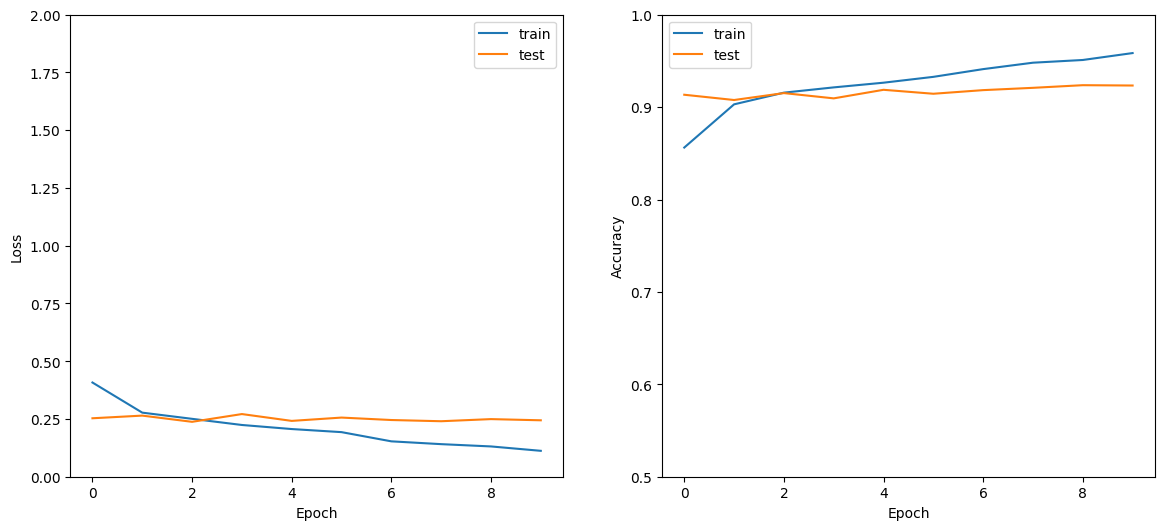

In [21]:
plot_history(history.history)

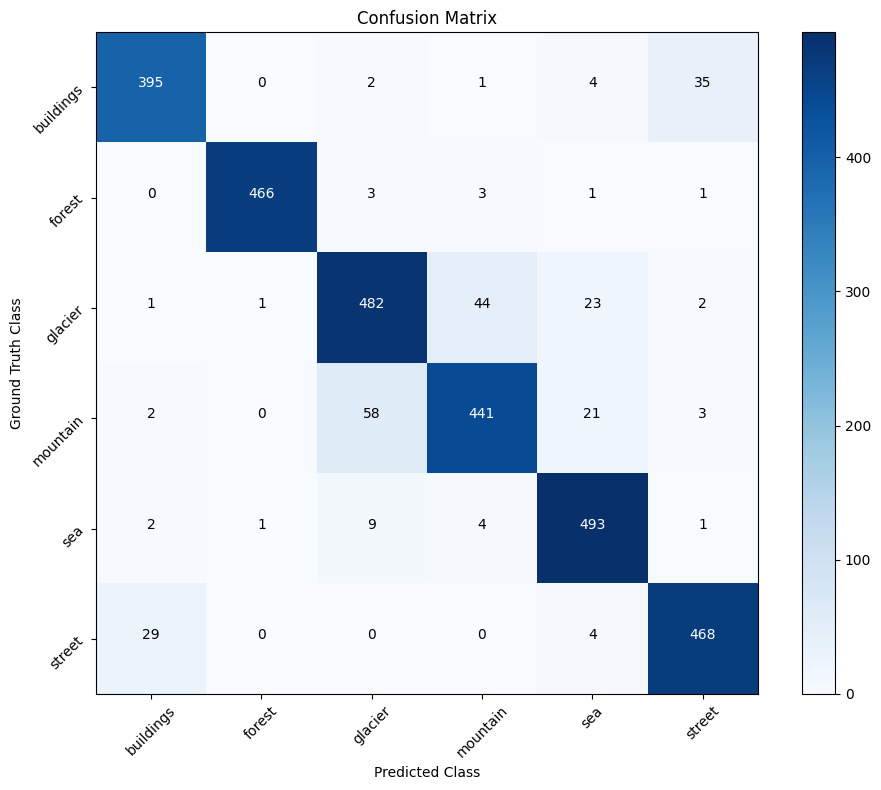

In [22]:
model.load_weights('weights/ResNet50_checkpoint.weights.h5')  
correct_labels, predicted_labels = print_confusion_matrix(model, test, classes) 

In [23]:
print(classification_report(correct_labels, predicted_labels, target_names=classes))

              precision    recall  f1-score   support

   buildings       0.92      0.90      0.91       437
      forest       1.00      0.98      0.99       474
     glacier       0.87      0.87      0.87       553
    mountain       0.89      0.84      0.87       525
         sea       0.90      0.97      0.93       510
      street       0.92      0.93      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.91      3000



## EfficientNetV2S

In [24]:
# Creazione del modello con backbone pre-addestrata
base_model = keras.applications.EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Costruzione del modello personalizzato
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(len(classes), activation='softmax')(x)

model = keras.Model(inputs, outputs)

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Callbacks
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='weights/EfficientNetV2S_checkpoint.weights.h5',
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    checkpoint_callback  # Aggiunto il callback per salvare i pesi
]

# Training the model
history = model.fit(train,
          epochs=10,  
          validation_data=validation,
          batch_size=64,
          callbacks=callbacks)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8227 - loss: 0.4801
Epoch 1: val_accuracy improved from -inf to 0.90449, saving model to weights/EfficientNetV2S_checkpoint.weights.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 473s 1s/step - accuracy: 0.8229 - loss: 0.4797 - val_accuracy: 0.9045 - val_loss: 0.2421 - learning_rate: 0.0010
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.9030 - loss: 0.2551
Epoch 2: val_accuracy improved from 0.90449 to 0.92623, saving model to weights/EfficientNetV2S_checkpoint.weights.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.9031 - loss: 0.2551 - val_accuracy: 0.9262 - val_loss: 0.1970 - learning_rate: 0.0010
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - accuracy: 0.9188 - loss: 0.2136
Epoch 3: val_accuracy did not improve from 0.92623
351/351 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.9188 - loss: 0.2136 - val_accuracy: 0.9191 - val_loss: 0.2087 - learning_rate: 0.0010
Epoch 4/10
351/351 ━━━━━━━━━━

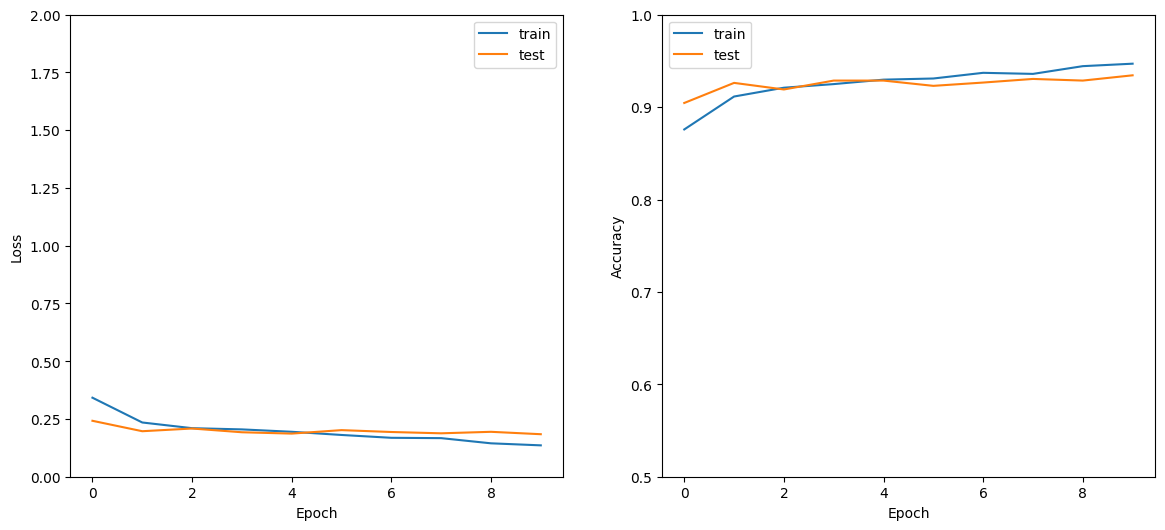

In [25]:
plot_history(history.history)

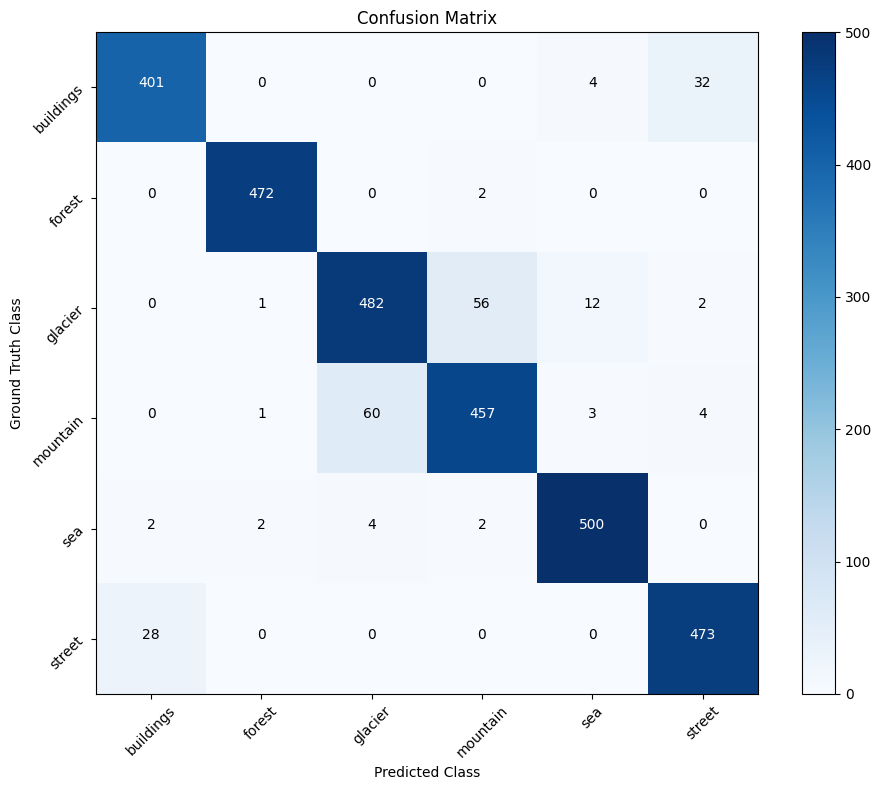

In [26]:
model.load_weights('weights/EfficientNetV2S_checkpoint.weights.h5')  
correct_labels, predicted_labels = print_confusion_matrix(model, test, classes)

In [27]:
print(classification_report(correct_labels, predicted_labels, target_names=classes))

              precision    recall  f1-score   support

   buildings       0.93      0.92      0.92       437
      forest       0.99      1.00      0.99       474
     glacier       0.88      0.87      0.88       553
    mountain       0.88      0.87      0.88       525
         sea       0.96      0.98      0.97       510
      street       0.93      0.94      0.93       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



## DenseNet201

In [28]:
# Creazione del modello con backbone pre-addestrata
base_model = keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Costruzione del modello personalizzato
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(len(classes), activation='softmax')(x)

model = keras.Model(inputs, outputs)

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Callbacks
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='weights/DenseNet201_checkpoint.weights.h5',
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    checkpoint_callback  # Aggiunto il callback per salvare i pesi
]

# Training the model
history = model.fit(train,
          epochs=10,  
          validation_data=validation,
          batch_size=64,
          callbacks=callbacks)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5147 - loss: 1.5924
Epoch 1: val_accuracy improved from -inf to 0.73806, saving model to weights/DenseNet201_checkpoint.weights.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 823s 2s/step - accuracy: 0.5149 - loss: 1.5911 - val_accuracy: 0.7381 - val_loss: 0.7204 - learning_rate: 0.0010
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6711 - loss: 0.8266
Epoch 2: val_accuracy improved from 0.73806 to 0.76016, saving model to weights/DenseNet201_checkpoint.weights.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 801s 2s/step - accuracy: 0.6712 - loss: 0.8266 - val_accuracy: 0.7602 - val_loss: 0.6513 - learning_rate: 0.0010
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7049 - loss: 0.7439
Epoch 3: val_accuracy improved from 0.76016 to 0.76764, saving model to weights/DenseNet201_checkpoint.weights.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 811s 2s/step - accuracy: 0.7049 - loss: 0.7438 - val_accuracy: 0.7676 - val_loss: 0.6405 - le

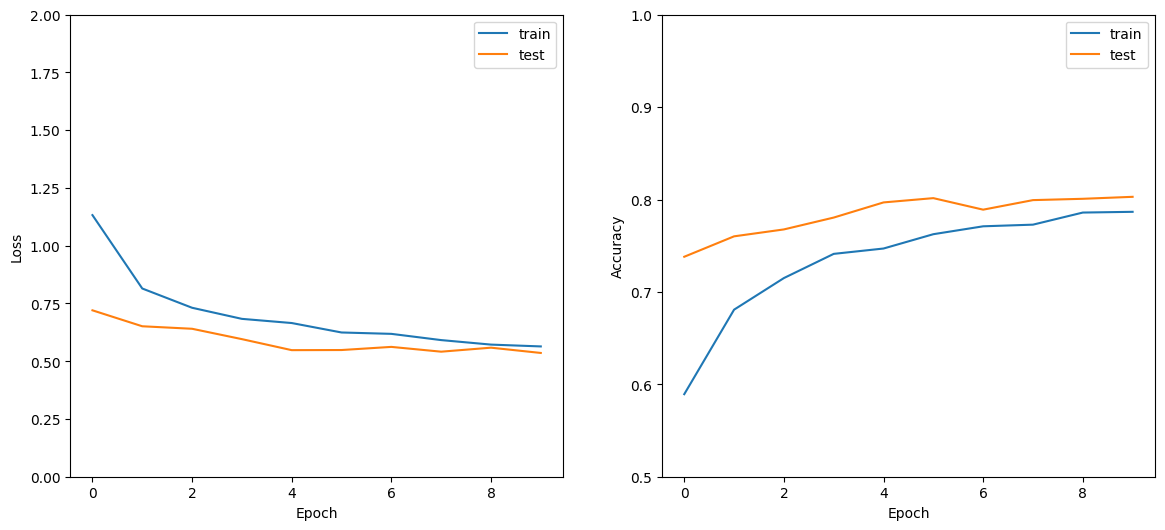

In [29]:
plot_history(history.history)

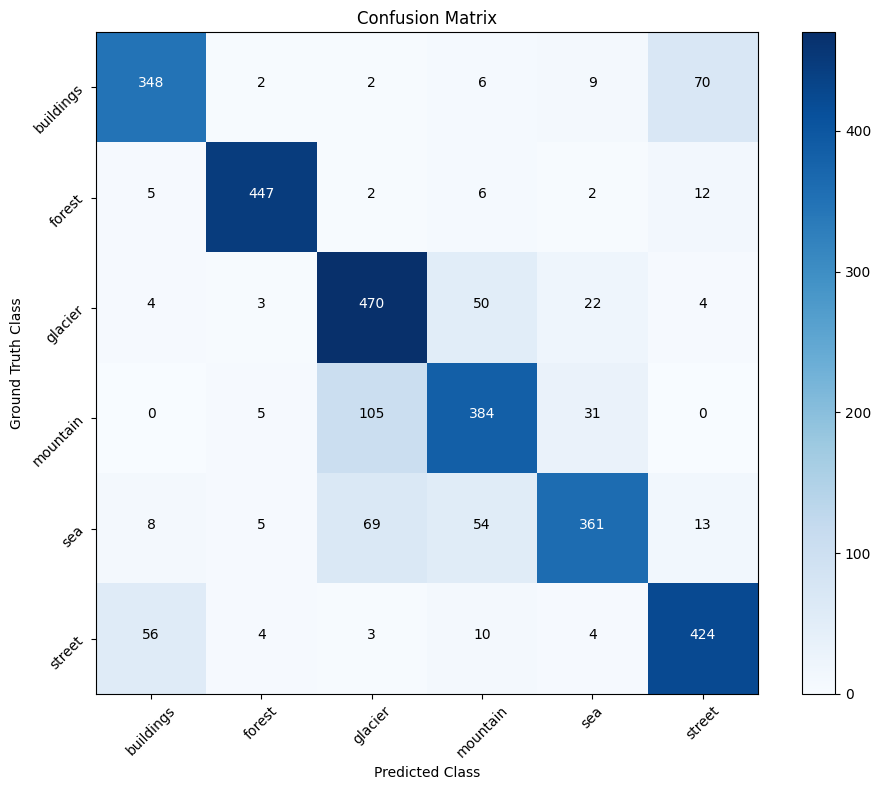

In [30]:
model.load_weights('weights/DenseNet201_checkpoint.weights.h5')  
correct_labels, predicted_labels = print_confusion_matrix(model, test, classes)

In [31]:
print(classification_report(correct_labels, predicted_labels, target_names=classes))

              precision    recall  f1-score   support

   buildings       0.83      0.80      0.81       437
      forest       0.96      0.94      0.95       474
     glacier       0.72      0.85      0.78       553
    mountain       0.75      0.73      0.74       525
         sea       0.84      0.71      0.77       510
      street       0.81      0.85      0.83       501

    accuracy                           0.81      3000
   macro avg       0.82      0.81      0.81      3000
weighted avg       0.82      0.81      0.81      3000

